In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten, Conv2D,\
                        BatchNormalization, Concatenate, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model

from src.analysis_tools import plot_confusion_matrix, extract_data
from src.cnn_models import basic_cnn, simple_cnn, dense_cnn, dense_cnn_multitask,\
                            transfer_densenet_model, coeff_determination, rmse

%load_ext autoreload
%autoreload 2

In [2]:
class DataGenerator(tf.compat.v2.keras.utils.Sequence):
 
    def __init__(self, X_data, labels, flowdata, n_classes, batch_size, dim,\
                 to_fit, shuffle = True):
        self.batch_size = batch_size
        self.X_data = X_data
        self.labels = labels
        self.flowdata = flowdata
        self.n_classes = n_classes
        #self.y_data = [labels, flowdata]
        self.to_fit = to_fit
        self.dim = dim
        self.shuffle = shuffle
        self.n = 0
        self.list_IDs = np.arange(len(self.X_data))
        self.on_epoch_end()
        
    def __next__(self):
        # Get one batch of data
        data = self.__getitem__(self.n)
        # Batch index
        self.n += 1
        
        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end
            self.n = 0
        
        return data
    
    def __len__(self):
        # Return the number of batches of the dataset
        return int(np.ceil(len(self.indexes)/self.batch_size))
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:
            (index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = self._generate_x(list_IDs_temp)
        
        if self.to_fit=='both':
            y = self._generate_y(list_IDs_temp)
            return X, y
        elif self.to_fit=='class':
            y = self._generate_ylabels(list_IDs_temp)
            return X, y
        elif self.to_fit=='flow':
            y = self._generate_yflow(list_IDs_temp)
            return X, y
        else:
            return X
   
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.X_data))
        
        if self.shuffle: 
            np.random.shuffle(self.indexes)
            
    def _generate_x(self, list_IDs_temp):
               
        X = np.empty((self.batch_size, *self.dim))
        
        for i, ID in enumerate(list_IDs_temp):
            
            X[i,] = self.X_data[ID]
            
            # Normalize data
            #X = (X/255.).astype('float32')
            
        return X/255.
    
    def _generate_y(self, list_IDs_temp):
        
        y_class = np.empty(self.batch_size)
        y_flow = np.empty(self.batch_size)
        
        for i, ID in enumerate(list_IDs_temp):
            
            y_class[i] = self.labels[ID]
            y_flow[i] = self.flowdata[ID]
            
        y = [keras.utils.to_categorical(
                y_class,num_classes=self.n_classes),\
             np.array(y_flow, dtype=np.float32)]
        return y
 
    def _generate_yflow(self, list_IDs_temp):
        
        y = np.empty(self.batch_size)
        
        for i, ID in enumerate(list_IDs_temp):
            
            y[i] = self.flowdata[ID]
            
        return y.reshape(-1,1)
    
    def _generate_ylabels(self, list_IDs_temp):
        
        y = np.empty(self.batch_size)
        
        for i, ID in enumerate(list_IDs_temp):
            
            y[i] = self.labels[ID]
            
        return keras.utils.to_categorical(
                y,num_classes=self.n_classes)

In [3]:
class FlowGenerator:

    def __init__(self, name: str, metadata_file: str, batch_size: int):
        self.name = name
        self.lookup_table = pd.read_csv(metadata_file)
        self.size = len(pd.read_csv(metadata_file))
        if batch_size is None:
            self.batch_size = self.size
        else:
            self.batch_size = batch_size
        self.generator = self.data_gen()
        
    def data_gen(self):
        data_indices = np.arange(self.size)
        n_batches = self.size // self.batch_size
        batch_list = np.random.permutation(self.size)
        for b in range(n_batches):
            permut = batch_list[b*self.batch_size:((b+1)*self.batch_size)]
            x_batch = np.array([np.asarray(Image.open(i['FILENAME'])) \
                                for _,i in self.lookup_table.iloc[permut].iterrows()])/255.
            y_batch = np.array([[i['DISCHARGE']] \
                                for _,i in self.lookup_table.iloc[permut].iterrows()])
        #yield tf.data.Dataset.from_tensor_slices((x_batch,y_batch))
        yield x_batch,y_batch
        

In [26]:
#load data

stations = ['GrantPoole','BrownsBrook','ParkersBrook']

station_name = stations[1]

set_type = ['train', 'val', 'test']
BATCH_SIZE = 4 
data_generators = {} 
stats = {}
num_classes = 5
for dataset in set_type:
    metadata_file = f'/datadrive/stream_data/training/{station_name}/{dataset}_table.csv'
    lookup_table = pd.read_csv(metadata_file)
    X = np.array([np.asarray(Image.open(i['FILENAME'])) \
                        for _,i in lookup_table.iterrows()])
    flow = np.array(lookup_table['LOG_DISCHARGE'])
    labels = np.array(lookup_table['KBIN'])
    #stats[dataset] = tools.norm_stats(flow)
    y = [labels, flow]
    input_shape = X.shape[1:]
    data_generators[dataset] = DataGenerator(X, labels, flow, num_classes,\
                                             BATCH_SIZE, input_shape, to_fit='both')

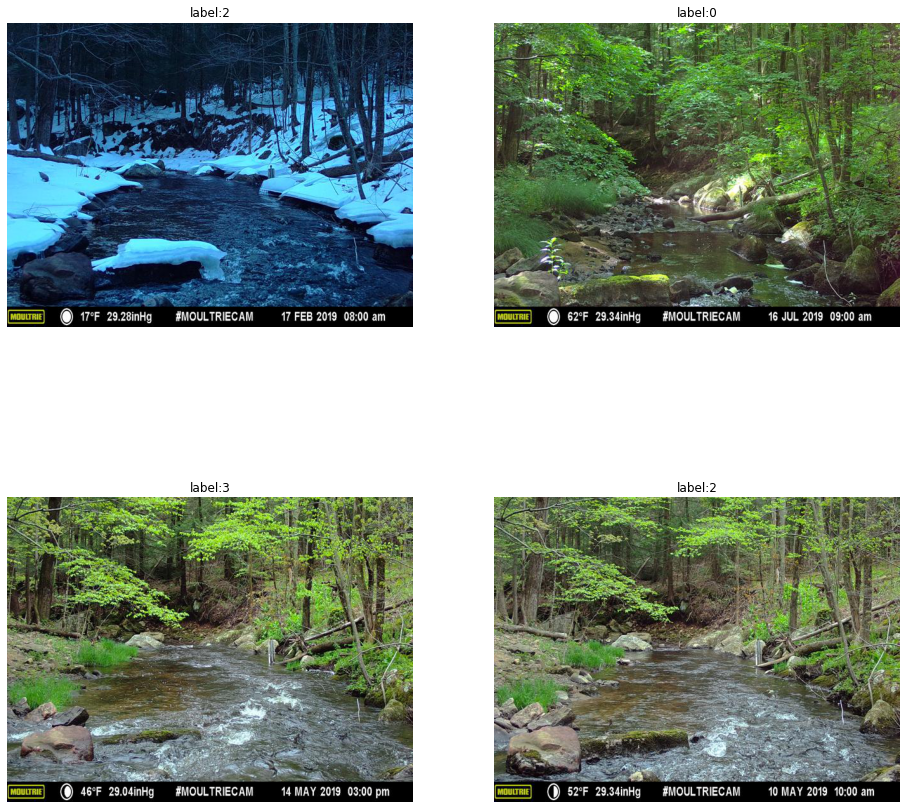

In [27]:
z = next(data_generators['train'])
r,c = (2,2)
f,ax = plt.subplots(r,c,figsize=(16,16))
i = 0
img = z[0]
label = np.argmax(z[1][0],axis=1)
flow = z[1][1]
for j in range(r):
    for k in range(c):
        ax[j,k].imshow(img[i])
        ax[j,k].set_title(f'label:{label[i]}, flow:{flow[i]:.2f}')
        ax[j,k].set_title(f'label:{label[i]}')
        ax[j,k].axis('off')
        i+=1

In [19]:
#class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
#                                                 np.unique(labels),
#                                                 labels)))

In [ ]:
input_shape = (480,600,3)
output_shape= [num_classes,1]
EPOCHS = 20 
n_dblocks=1
#model = basic_cnn(input_shape=input_shape,\
#                  output_shape=output_shape,\
#                  final_activation='relu')
#model = simple_cnn(input_shape=input_shape, output_shape=output_shape,\
        #final_activation='relu')
model = dense_cnn_multitask(input_shape=input_shape, n_dblocks=n_dblocks,\
                  output_shape=output_shape)
model.summary()
lr = 0.001
opt = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.1)
#loss = 'mean_squared_error'

#def rmse(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
loss = ['categorical_crossentropy', rmse]

#metrics = ['accuracy',tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))]
metrics = ['accuracy', coeff_determination]
model.compile(loss=loss, optimizer=opt, metrics=metrics)
model_history = model.fit_generator(data_generators['train'],\
                                        steps_per_epoch=len(data_generators['train']),
                                        epochs=EPOCHS)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 480, 600, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 600, 16) 48          input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 480, 600, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 480, 600, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Epoch 1/20
551/551 [==============================] - 120s 217ms/step - loss: 3.5632 - fc_class_layer_loss: 1.6058 - fc_flow_layer_loss: 1.9571 - fc_class_layer_accuracy: 0.3761 - fc_class_layer_coeff_determination: 0.0018 - fc_flow_layer_accuracy: 0.0000e+00 - fc_flow_layer_coeff_determination: -5.7079
Epoch 2/20
551/551 [==============================] - 120s 218ms/step - loss: 3.5659 - fc_class_layer_loss: 1.6044 - fc_flow_layer_loss: 1.9615 - fc_class_layer_accuracy: 0.3911 - fc_class_layer_coeff_determination: 0.0025 - fc_flow_layer_accuracy: 0.0000e+00 - fc_flow_layer_coeff_determination: -3.2465
Epoch 3/20
393/551 [====================>.........] - ETA: 34s - loss: 3.5622 - fc_class_layer_loss: 1.6044 - fc_flow_layer_loss: 1.9578 - fc_class_layer_accuracy: 0.3912 - fc_class_layer_coeff_determination: 0.0025 - fc_flow_layer_accuracy: 0.0000e+00 - fc_flow_layer_coeff_determination: -3.9970

In [240]:
model.predict(val)

[array([[0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319],
        [0.6188305 , 0.20255627, 0.17861319]], dtype=float32),
 array([[0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381],
        [0.6254381]], dtype=float32)]

In [25]:
input_shape = (480,600,3)
output_shape = num_classes
EPOCHS = 5
LR = 0.001

#model = dense_cnn(input_shape=input_shape, n_dblocks=n_dblocks,\
#                  output_shape=output_shape)

model = transfer_densenet_model(input_shape=input_shape,n_classes=output_shape)
model.summary()

opt = tfa.optimizers.AdamW(learning_rate=LR, weight_decay=0.1)
   
loss = ['categorical_crossentropy']

#metrics = ['accuracy',tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))]
metrics = ['categorical_accuracy']
model.compile(loss=loss, optimizer=opt, metrics=metrics)
model_history = model.fit(data_generators['train'],\
                                        steps_per_epoch=len(data_generators['train']),\
                                        validation_data=data_generators['val'],\
                                        epochs=EPOCHS)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 480, 600, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 486, 606, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 240, 300, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 240, 300, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

Epoch 1/5
288/551 [==============>...............] - ETA: 2:09 - loss: 13.1585 - categorical_accuracy: 0.3681

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

class TestModel(Model):
    def __init__(self):
        super(TestModel, self).__init__()
        self.conv1 = Conv2D(filters=8, kernel_size=(32, 32), activation='relu')
        self.conv2 = Conv2D(filters=4, kernel_size=(16, 16), activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(8, activation='relu')
        self.d2 = Dense(1)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.d1(x)
        return self.d2(x)


model = TestModel()

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
#train_accuracy = tfa.metrics.RSquare(name='train_R2')
#test_accuracy = tfa.metrics.RSquare(name='test_R2')
train_accuracy = tf.keras.metrics.RootMeanSquaredError(name='train_RMSE')
test_accuracy = tf.keras.metrics.RootMeanSquaredError(name='test_RMSE')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different behavior
    # during training versus inference (e.g. Dropout)
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [49]:
EPOCHS = 2 
BATCH_SIZE = 16 
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_dataset.batch(BATCH_SIZE):
        train_step(images, labels)
        
    for test_images, test_labels in test_dataset.batch(BATCH_SIZE):
        test_step(test_images, test_labels)
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f},\
                Test Loss: {:.2f}, Test Accuracy: {:.2f}'
    #template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(f'')
    print(template.format(epoch + 1,
                        train_loss.result(),\
                        test_loss.result(),\
                        train_accuracy.result(),\
                        test_accuracy.result()))


Epoch 1, Loss: 0.87, Accuracy: 0.93,                Test Loss: 0.93, Test Accuracy: 0.97

Epoch 2, Loss: 0.50, Accuracy: 0.53,                Test Loss: 0.71, Test Accuracy: 0.73


In [ ]:
#build model and fit

#BATCH_SIZE = 8 
#train_dataset = train_dataset.batch(BATCH_SIZE)
#test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
input_shape = tuple(ex['shape'])
output_shape = 1

In [10]:
output_shape

1

In [16]:
model = basic_cnn(input_shape=input_shape,\
                  output_shape=output_shape,\
                  final_activation='relu')
#model = simple_cnn(input_shape=input_shape, output_shape=output_shape)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 960, 1280, 3)]    0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 960, 1280, 16)     448       
_________________________________________________________________
batch_normalization_22 (Batc (None, 960, 1280, 16)     64        
_________________________________________________________________
activation_18 (Activation)   (None, 960, 1280, 16)     0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 960, 1280, 16)     64        
_________________________________________________________________
dense_5 (Dense)              (None, 960, 1280, 10)     170       
_________________________________________________________________
output_layer (Dense)         (None, 960, 1280, 1)     

In [20]:
opt = Adam(lr=0.0001)
epochs = 10 
model.compile(loss=rmse, optimizer=opt, metrics=[coeff_determination])

In [21]:
model.fit(train_dataset, epochs)

ValueError: `y` argument is not supported when using dataset as input.

In [ ]:
shift = 7 
r_range = 5 
batch_size = 8 
brightness_range=(0.8,1)
datagen = ImageDataGenerator(rescale=1./255,\
                             rotation_range=r_range,\
                             width_shift_range=shift,\
                             height_shift_range=shift,\
                             brightness_range=brightness_range)
datagen.fit(x_train, augment=True, seed=1234)

In [ ]:
z = next(datagen.flow(x_train,y_train, batch_size))
f, ax = plt.subplots(1,batch_size, figsize=(20,10))
for i in range(batch_size):
    ax[i].imshow(z[0][i])
    ax[i].set_axis_off()

In [19]:
opt = Adam(lr=0.0001)
epochs = 10 
model.compile(loss=rmse, optimizer=opt, metrics=[coeff_determination])

acc_hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size), \
                               steps_per_epoch=len(x_train)/batch_size, \
                               epochs=epochs, \
                               class_weight=class_weights,\
                               validation_data=(x_test, y_test))

NameError: name 'datagen' is not defined

In [ ]:
if hist:
    hist_add = acc_hist.history
    for k in hist.keys():
        hist[k].extend(hist_add[k])
else:
    hist = acc_hist.history

In [ ]:
#hist = acc_hist.history
f, ax = plt.subplots(2,1,figsize=(10,8))
for k in hist.keys():
    if 'loss' in k:
        ax[0].plot(hist[k], label=k)
    else:
        ax[1].plot(hist[k], label=k)
ylabels = ['Loss', 'Accuracy']
for i in range(2):
    ax[i].legend()
    ax[i].grid(alpha=0.5)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel('Epoch')
f.savefig('/content/output/accuracy.png', dpi=100, bbox_inches='tight', pad_inches=0)

In [ ]:
y_hat = model.predict(x_test)
ii = 7 
jj = 7
sample_i = np.random.choice(len(x_test), ii*jj, replace=False).reshape((ii,jj))
label = ['low flow','mid flow','high flow']
color = ['orange', 'darkblue']
f,ax = plt.subplots(ii, jj, figsize=(18,30))
for i in range(ii):
    for j in range(jj):
        s = sample_i[i][j]
        ax[i][j].imshow(x_test[s])
        ax[i][j].set_axis_off()
        ax[i][j].set_title('%s\nFlowrate: %s\nTrue:%s\nPredicted:%s'%(dates_test[s],y_test_flow[s],\
                                             label[np.argmax(y_test[s])],label[np.argmax(y_hat[s])]),\
                                                         color=color[np.argmax(y_test[s])==np.argmax(y_hat[s])])
f.savefig('/content/output/validation.png', dpi=100, bbox_inches='tight', pad_inches=0)

In [ ]:
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_hat,axis=1))
plot_confusion_matrix(cm, classes=label, outname='/content/output/conf_mat.png')

In [ ]:
model_json = model.to_json()
with open("/content/output/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/output/model.h5")
print("Saved model to disk")
plot_model(model, to_file='/content/output/model_graph.png')